<h1>Project: prediction of the mechanical properties using the alloy composition and temperature</h1>

Dataset: "Mechanical properties of low alloy steels" from Kaggle, Contains alloy composition, temperature and mechanical properties

Context: currently there are no precise theoretical methods to predict mechanical properties of steels. All the methods available are by backed by statistics and extensive physical testing of the materials. Since testing each material with different composition is a highly tedious task (imagine the number of possibilities!), let's apply our knowledge of machine learning and statistics to solve this problem.

Content: this dataset contains compositions by weight percentages of low-alloy steels along with the temperatures at which the steels were tested and the values mechanical properties observed during the tests. The alloy code is a string unique to each alloy. Weight percentages of alloying metals and impurities like Aluminum, copper, manganese, nitrogen, nickel, cobalt, carbon, etc are given in columns. The temperature in celsius for each test is mentioned in a column. Lastly mechanical properties including tensile strength, yield strength, elongation and reduction in area are given in separate columns. The dataset contains 915 rows.

Link to the dataset:

https://www.kaggle.com/rohannemade/mechanical-properties-of-low-alloy-steels

<h4>Steps:</h4>
<ol>
  <li>Data Analysis</li>
  <li>Feature Engineering</li>
  <li>Feature Selection</li>
  <li>Model Training</li>
  <li>Obtaining Predictions / Scoring</li>
</ol>

<b>Dependencies and versions</b>

In [1]:
# importing libraries
from platform import python_version
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats


import warnings
warnings.filterwarnings("ignore")

In [2]:
# showing versions
print('Python version:',python_version())
print('NumPy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('SciPy version:',scipy.__version__)

Python version: 3.8.8
NumPy version: 1.20.2
Pandas version: 1.2.4
SciPy version: 1.6.2


<h2>STEP 1: Data analysis</h2>

In [3]:
# importing the dataset
df = pd.read_csv("MatNavi Mechanical properties of low-alloy steels.csv")

In [4]:
# displaying columns
df.columns

Index(['Alloy code', ' C', ' Si', ' Mn', ' P', ' S', ' Ni', ' Cr', ' Mo',
       ' Cu', 'V', ' Al', ' N', 'Ceq', 'Nb + Ta', ' Temperature (°C)',
       ' 0.2% Proof Stress (MPa)', ' Tensile Strength (MPa)',
       ' Elongation (%)', ' Reduction in Area (%)'],
      dtype='object')

In [5]:
# removing spaces in column names
cols = df.columns
cols = [item.strip() for item in cols]
df.columns = cols
df.columns

Index(['Alloy code', 'C', 'Si', 'Mn', 'P', 'S', 'Ni', 'Cr', 'Mo', 'Cu', 'V',
       'Al', 'N', 'Ceq', 'Nb + Ta', 'Temperature (°C)',
       '0.2% Proof Stress (MPa)', 'Tensile Strength (MPa)', 'Elongation (%)',
       'Reduction in Area (%)'],
      dtype='object')

In [6]:
# shape
df.shape

(915, 20)

In [7]:
# showing first five rows of the training dateset
pd.pandas.set_option('display.max_columns', None, 'display.max_rows', None, )
df.head()

,Alloy code,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C),0.2% Proof Stress (MPa),Tensile Strength (MPa),Elongation (%),Reduction in Area (%)
0,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27,342,490,30,71
1,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100,338,454,27,72
2,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200,337,465,23,69
3,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300,346,495,21,70
4,MBB,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400,316,489,26,79


In [8]:
# showing data types
df.dtypes

Alloy code                  object
C                          float64
Si                         float64
Mn                         float64
P                          float64
S                          float64
Ni                         float64
Cr                         float64
Mo                         float64
Cu                         float64
V                          float64
Al                         float64
N                          float64
Ceq                        float64
Nb + Ta                    float64
Temperature (°C)             int64
0.2% Proof Stress (MPa)      int64
Tensile Strength (MPa)       int64
Elongation (%)               int64
Reduction in Area (%)        int64
dtype: object

<b>Target</b>

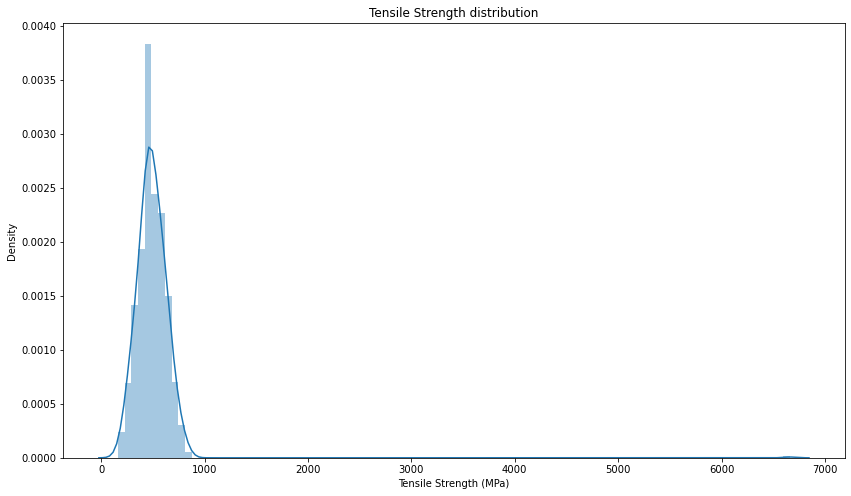

In [9]:
# plotting distribution of the target
plt.figure(figsize=(14,8))

ax = sns.distplot(df['Tensile Strength (MPa)'],bins=100)

plt.title('Tensile Strength distribution')
plt.xlabel('Tensile Strength (MPa)')

plt.show()

<b>Variables types</b>

In [10]:
# identifying the categorical variables
# capturing those of type 'object'
cat_vars = [var for var in df.columns if df[var].dtype == 'O']
# number of categorical variables
len(cat_vars)

1

In [11]:
# now let's identify the numerical variables
num_vars = [var for var in df.columns if var not in cat_vars and var not in \
            ('0.2% Proof Stress (MPa)', 'Tensile Strength (MPa)', 'Elongation (%)', 'Reduction in Area (%)')]

# number of numerical variables
len(num_vars)

15

<b>Missing values</b>

In [12]:
# checking duplicated rows
df.duplicated().sum()

0

In [13]:
# checking missing values
df.isnull().any(axis = 1).sum()

0

<b>Numerical variables</b>

In [14]:
print('Number of numerical variables: ', len(num_vars))

# visualise the numerical variables
df[num_vars].head()

Number of numerical variables:  15


,C,Si,Mn,P,S,Ni,Cr,Mo,Cu,V,Al,N,Ceq,Nb + Ta,Temperature (°C)
0,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,27
1,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,100
2,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,200
3,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,300
4,0.12,0.36,0.52,0.009,0.003,0.089,0.97,0.61,0.04,0.0,0.003,0.0066,0.0,0.0,400


<b>Discrete variables</b>

In [15]:
#  let's male a list of discrete variables
discrete_vars = [var for var in num_vars if len(df[var].unique()) < 25]
print('Number of discrete variables: ', len(discrete_vars))

Number of discrete variables:  8


In [16]:
# visualising the discrete variables
df[discrete_vars].head()

,C,P,S,Cu,V,Ceq,Nb + Ta,Temperature (°C)
0,0.12,0.009,0.003,0.04,0.0,0.0,0.0,27
1,0.12,0.009,0.003,0.04,0.0,0.0,0.0,100
2,0.12,0.009,0.003,0.04,0.0,0.0,0.0,200
3,0.12,0.009,0.003,0.04,0.0,0.0,0.0,300
4,0.12,0.009,0.003,0.04,0.0,0.0,0.0,400


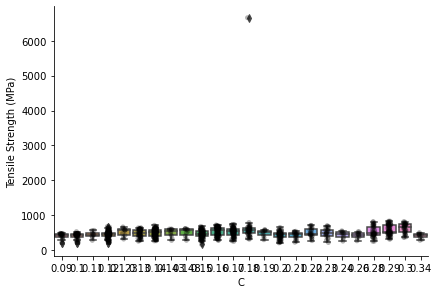

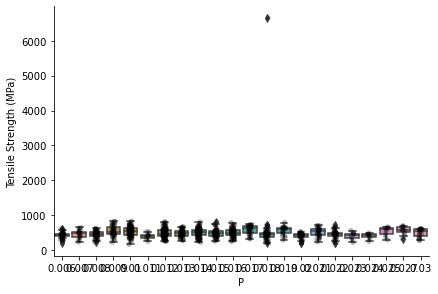

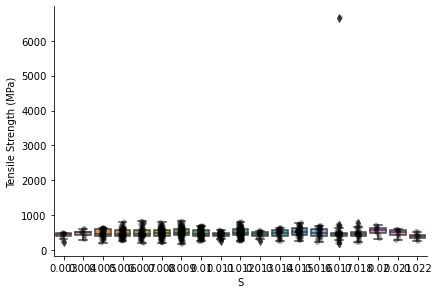

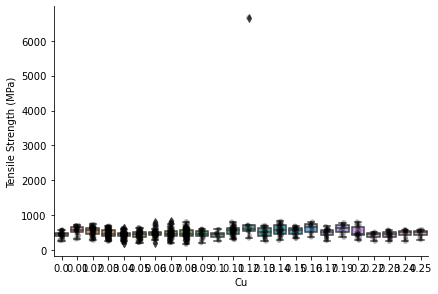

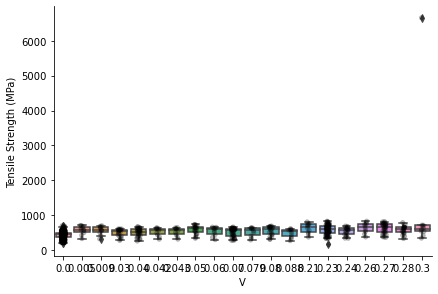

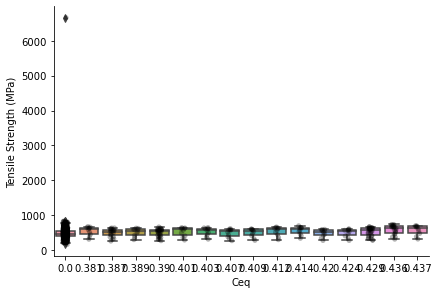

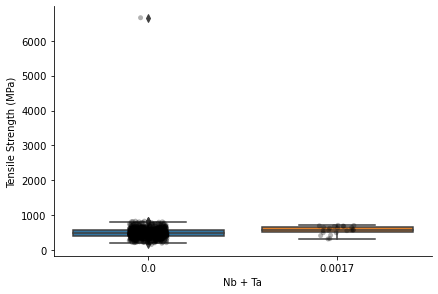

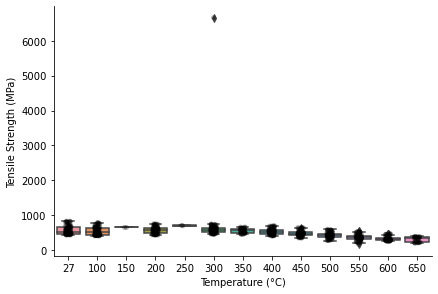

In [17]:
for var in discrete_vars:
    # make boxplot with Catplot
    sns.catplot(x=var, y='Tensile Strength (MPa)', data=df, kind="box", height=4, aspect=1.5)
    # add data points to boxplot with stripplot
    sns.stripplot(x=var, y='Tensile Strength (MPa)', data=df, jitter=0.1, alpha=0.3, color='k')
    plt.show()

All the variables seem predictive

<b>Continuous variables</b>

Finding the distribution of the continuous variables

In [18]:
# making list of continuous variables
cont_vars = [var for var in num_vars if var not in discrete_vars]

print('Number of continuous variables: ', len(cont_vars))

Number of continuous variables:  7


In [19]:
# visualising the continuous variables
df[cont_vars].head()

,Si,Mn,Ni,Cr,Mo,Al,N
0,0.36,0.52,0.089,0.97,0.61,0.003,0.0066
1,0.36,0.52,0.089,0.97,0.61,0.003,0.0066
2,0.36,0.52,0.089,0.97,0.61,0.003,0.0066
3,0.36,0.52,0.089,0.97,0.61,0.003,0.0066
4,0.36,0.52,0.089,0.97,0.61,0.003,0.0066


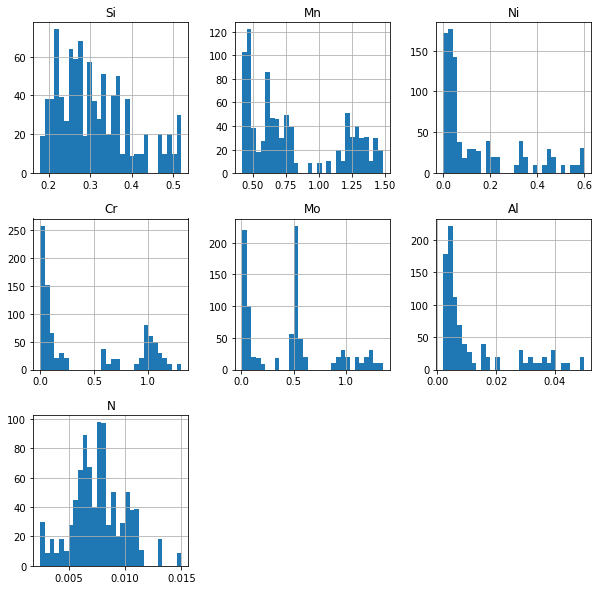

In [20]:
# plotting histograms for all continuous numerical variables
df[cont_vars].hist(bins=30, figsize=(10,10))
plt.show()

In [21]:
# function to create histogram, Q-Q plot and boxplot
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

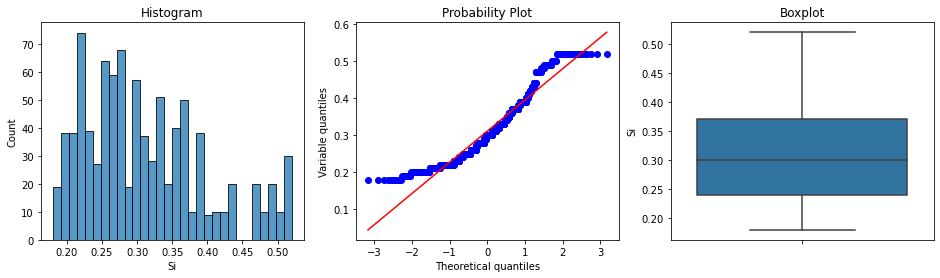

skewness of Si is 0.75


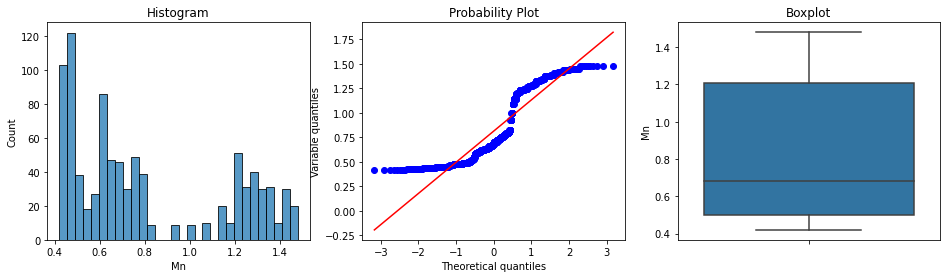

skewness of Mn is 0.61


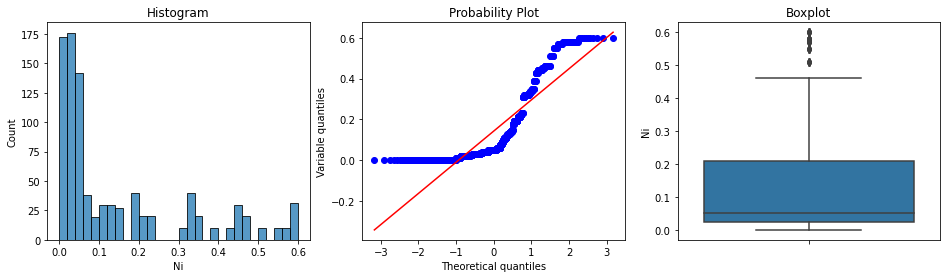

skewness of Ni is 1.29


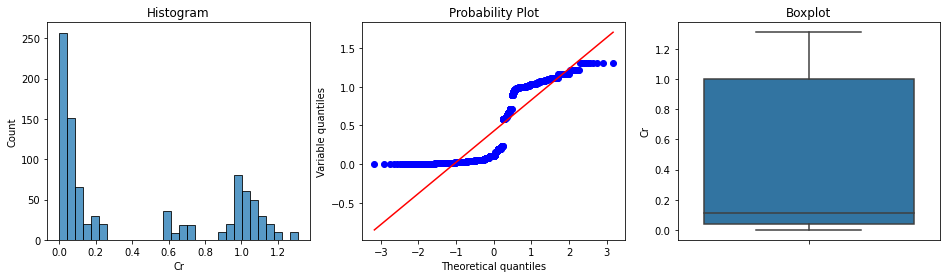

skewness of Cr is 0.53


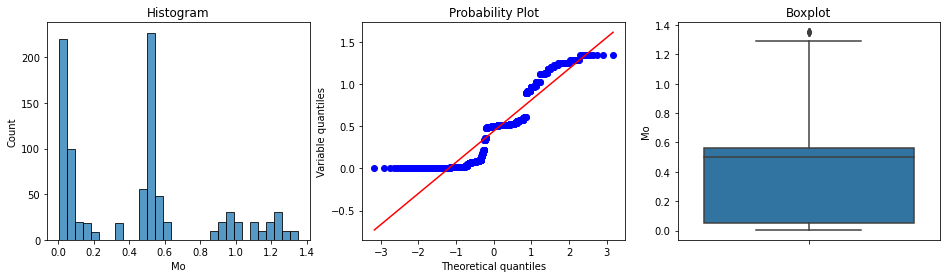

skewness of Mo is 0.62


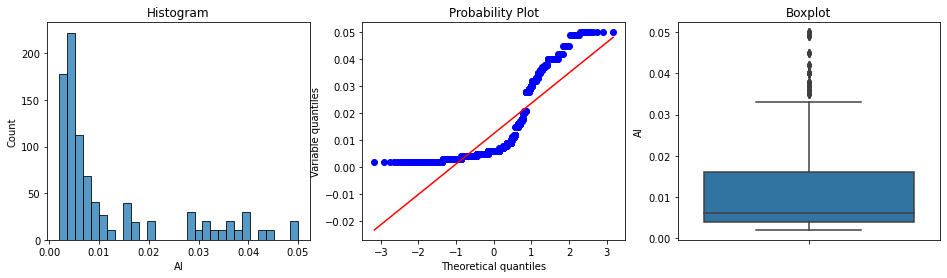

skewness of Al is 1.43


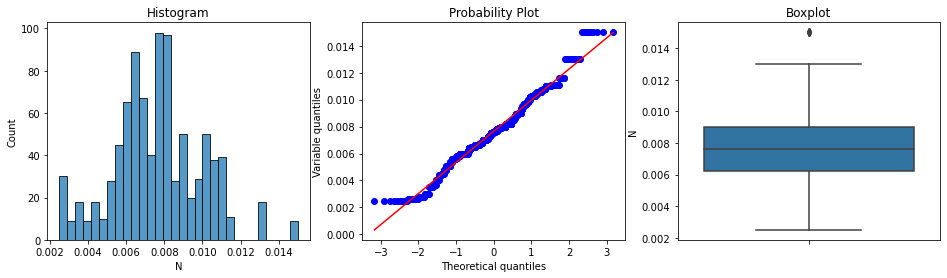

skewness of N is 0.23


In [22]:
# plotting the continuous variables
for variable in cont_vars:
    diagnostic_plots(df, variable)
    # printing skewness
    skewness = df[variable].skew()
    print("skewness of", variable, "is {:.2f}".format(skewness))

Yeo-Johnson transformation

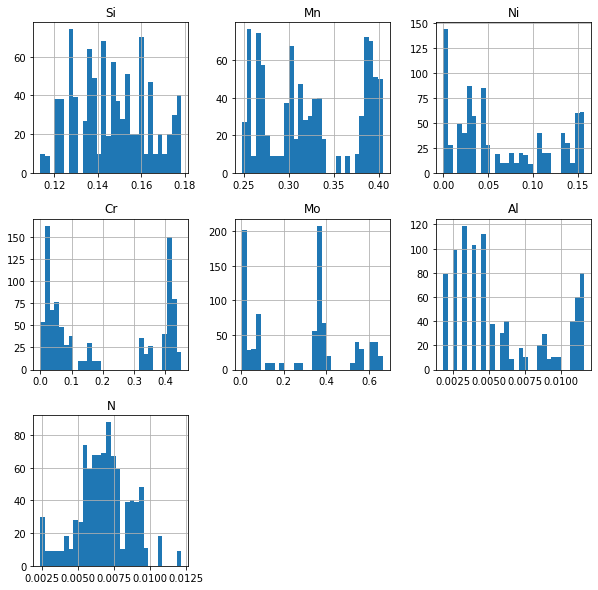

In [23]:
# Analysing the distributions of the variables after applying a yeo-johnson transformation

# temporary copy of the data
tmp = df.copy()

for var in cont_vars:

    # transform the variable - yeo-johsnon
    tmp[var], param = stats.yeojohnson(tmp[var])

    
# plot the histograms of the transformed variables
tmp[cont_vars].hist(bins=30, figsize=(10,10))
plt.show()

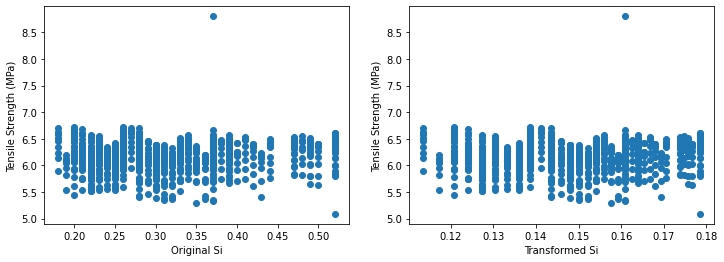

Original skewness 0.75, transformed skewness 0.10


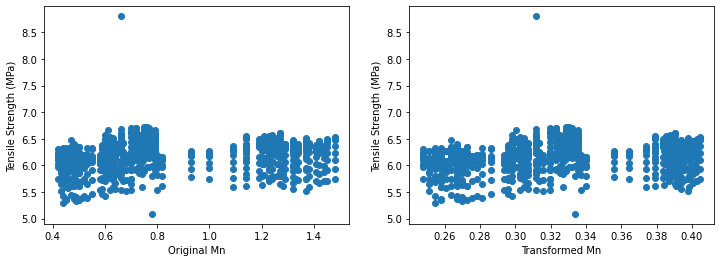

Original skewness 0.61, transformed skewness 0.19


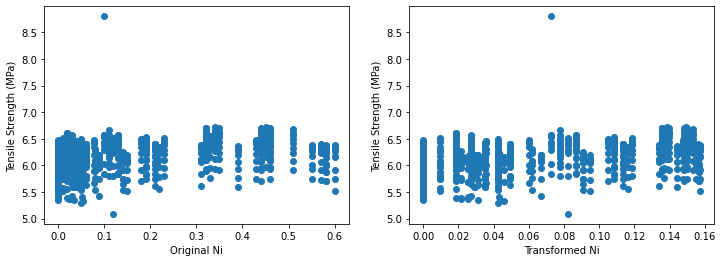

Original skewness 1.29, transformed skewness 0.46


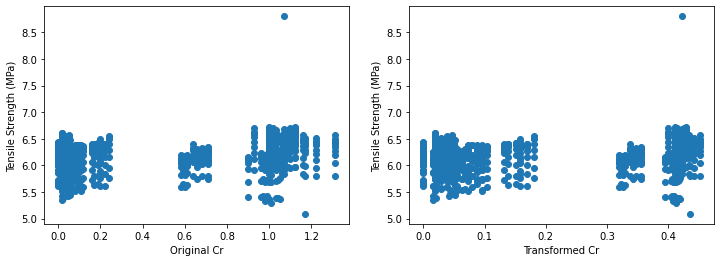

Original skewness 0.53, transformed skewness 0.32


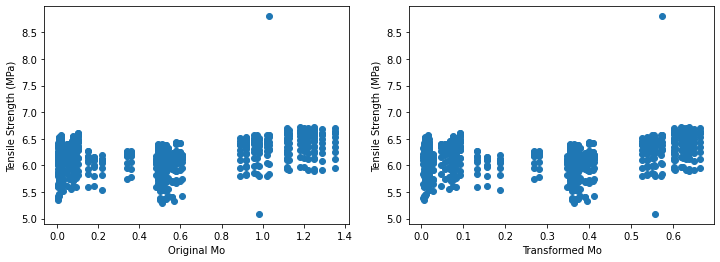

Original skewness 0.62, transformed skewness 0.07


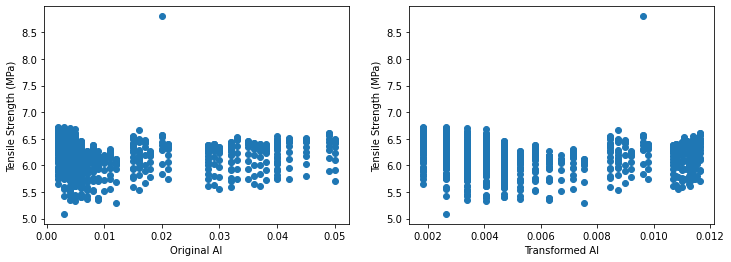

Original skewness 1.43, transformed skewness 0.63


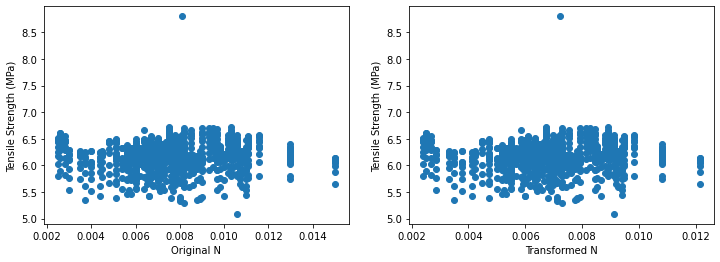

Original skewness 0.23, transformed skewness -0.01


In [24]:
# plotting the original or transformed variables vs credit score and seeing if there is a relationship

for var in cont_vars:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(df[var], np.log(df['Tensile Strength (MPa)']))
    plt.ylabel('Tensile Strength (MPa)')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(df['Tensile Strength (MPa)']))
    plt.ylabel('Tensile Strength (MPa)')
    plt.xlabel('Transformed ' + var)
                
    plt.show()
    print('Original skewness {:.2f}, transformed skewness {:.2f}'.format(df[var].skew(), tmp[var].skew()))


Yeo-Johnson transformation slightly improved predectibility of all the variables

Log transoformation of variables Si, Mn and N

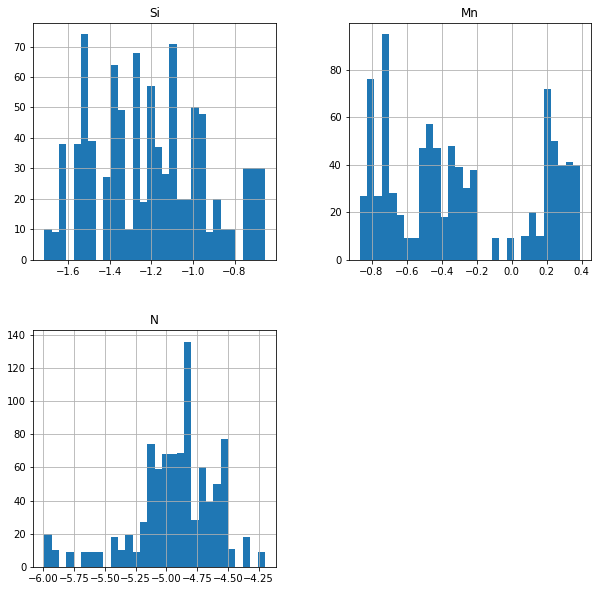

In [25]:
# Analysing the distributions of the variables after applying a log transformation

# temporary copy of the data
tmp = df.copy()

for var in ['Si', 'Mn', 'N']:

    # transform the variable - log
    tmp[var] = np.log(tmp[var])

    
# plot the histograms of the transformed variables
tmp[['Si', 'Mn', 'N']].hist(bins=30, figsize=(10,10))
plt.show()

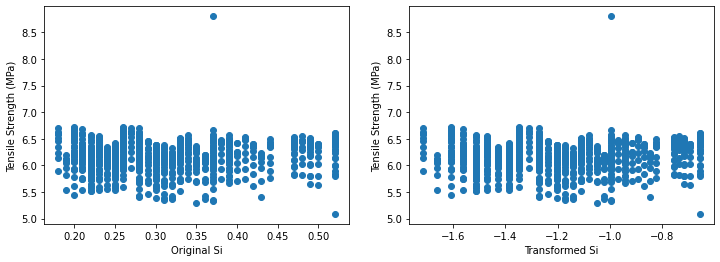

Original skewness 0.75, transformed skewness 0.28


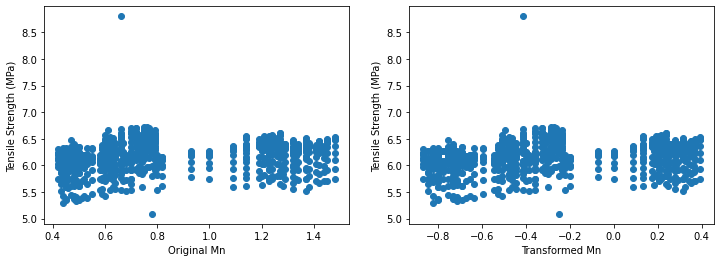

Original skewness 0.61, transformed skewness 0.31


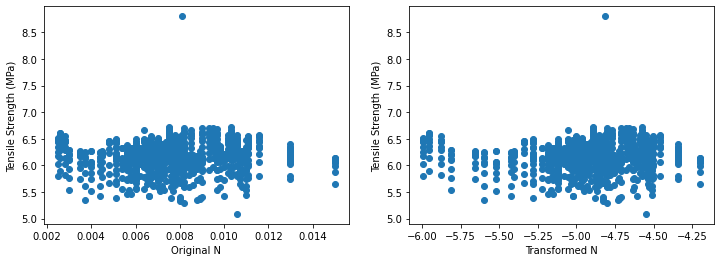

Original skewness 0.23, transformed skewness -0.96


In [26]:
# plotting the original or transformed variables vs credit score and seeing if there is a relationship

for var in ['Si', 'Mn', 'N']:
    
    plt.figure(figsize=(12,4))
    
    # plot the original variable vs sale price    
    plt.subplot(1, 2, 1)
    plt.scatter(df[var], np.log(df['Tensile Strength (MPa)']))
    plt.ylabel('Tensile Strength (MPa)')
    plt.xlabel('Original ' + var)

    # plot transformed variable vs sale price
    plt.subplot(1, 2, 2)
    plt.scatter(tmp[var], np.log(df['Tensile Strength (MPa)']))
    plt.ylabel('Tensile Strength (MPa)')
    plt.xlabel('Transformed ' + var)
                
    plt.show()
    print('Original skewness {:.2f}, transformed skewness {:.2f}'.format(df[var].skew(), tmp[var].skew()))

Log transformation improves predictibility of variables 'Si' and ' Mn'